<a href="https://colab.research.google.com/github/quolc/neural-collage/blob/feature/notebook/NeuralCollage_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## install required packages

In [0]:
!set -ex
!apt -y -q install cuda-libraries-dev-9-2
!pip install cupy-cuda92
!pip install chainer

In [0]:
!pip install scipy==1.0.0 chainercv==0.11.0 pyamg

In [0]:
# check gpu support
import chainer
chainer.cuda.get_device(0).use()

## setup neural-collage repository

In [0]:
!git clone https://github.com/quolc/neural-collage.git

In [0]:
%cd neural-collage/

## download pre-trained models

In [0]:
!mkdir sn_projection_dog_and_cat_256_large

In [0]:
# download model files
!wget "https://drive.google.com/uc?export=download&id=1U9ETQvZvJ3Fw9_BGe38TGaf9Keth8Z7v" -O sn_projection_dog_and_cat_256_large/ResNetGenerator_450000.npz
!wget "https://drive.google.com/uc?export=download&id=1oJOAWlSJy1vPRrFF9UwpXBKyK1QLt7eP" -O sn_projection_dog_and_cat_256_large/SNResNetProjectionDiscriminator_450000.npz
!wget "https://drive.google.com/uc?export=download&id=1XEOH5QhgrUX8P1jr8tcIGlPZegKobBuF" -O sn_projection_dog_and_cat_256_large/ResNetEncoder_450000.npz
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=16EHIj4w99nwP0fPg691-t4GO1_H4FBzp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=16EHIj4w99nwP0fPg691-t4GO1_H4FBzp" -O ./sn_projection_dog_and_cat_256_large/ResNetAuxABGenerator_75000.npz && rm -rf /tmp/cookies.txt

# Image Editing Workflow

In [0]:
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

## download image

In [0]:
!wget "https://drive.google.com/uc?export=download&id=13K4E1Ioqou_7iHkTatSVDdgLlQMkTthG" -O input.png

## 1. load image

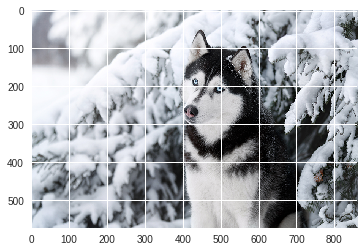

In [84]:
### INPUT ###
src_image = "./input.png"
src_class = 250 - 151 # ImageNet class-id of Husky (151 is offset for dog/cat subset)
### INPUT ###

img_src = np.array(Image.open(src_image))

# preview
plt.imshow(img_src)

## 2. set editing region

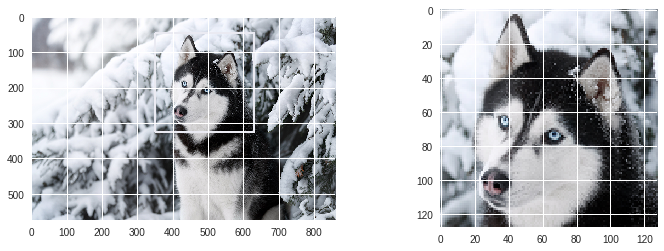

In [90]:
### INPUT ###
center_of_region = (490, 185) # (x, y) position
side_of_region = 280
### INPUT ###

left = int(center_of_region[0] - side_of_region/2)
top = int(center_of_region[1] - side_of_region/2)
cropped = img_src[top:top+side_of_region, left:left+side_of_region, :3]

# region preview
img_preview = cv2.rectangle(np.array(img_src),
                            (left, top), (left+side_of_region, top+side_of_region),
                            (255, 0, 0), thickness=3)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(img_preview)

# image patch preview
patch_src = cv2.resize(cropped, (128, 128))
plt.subplot(1,2,2)
plt.imshow(patch_src)

Image.fromarray(patch_src).save("patch_src.png")

## 3. manifold projection (with optimization.py)

In [0]:
argument = "--config_path ./configs/sn_projection_dog_and_cat_256_auxab.yml \
--gpu 0 \
--gen_model ./sn_projection_dog_and_cat_256_large/ResNetAuxABGenerator_75000.npz \
--dis_model ./sn_projection_dog_and_cat_256_large/SNResNetProjectionDiscriminator_450000.npz \
--enc_model ./sn_projection_dog_and_cat_256_large/ResNetEncoder_450000.npz \
--src_class {} \
--input patch_src.png \
--iter_opt 200 \
--mode aux".format(src_class)

!python optimization.py $argument
!mv opt_output/opt_final.npy src.npy

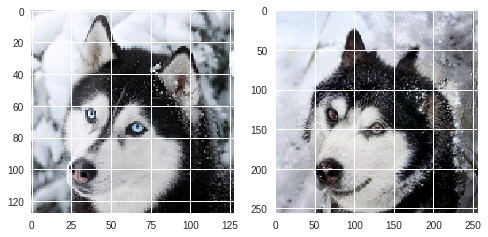

In [19]:
# preview
patch_recon = np.asarray(Image.open("opt_output/opt_final.png"))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(patch_src)
plt.subplot(1,2,2)
plt.imshow(patch_recon)

## 4. modulated image reconstruction

### 4-1. spatial translation

In [0]:
### INPUT ###
target_class = 196 - 151
### INPUT ###

# prepare mask image
!wget "https://drive.google.com/uc?export=download&id=1KbNlj7nbotynMcRx92P4jqjURNbG6nHr" -q -O mask.png

argument = "--gpu 0 \
--config ./configs/sn_projection_dog_and_cat_256_scbn.yml \
--snapshot sn_projection_dog_and_cat_256_large/ResNetGenerator_450000.npz \
--results_dir log/gen_spatially_interpolated_images \
--z_file ./opt_output/opt_final.npy \
--rows 1 \
--class_mask ./mask.png \
--classes {} {}".format(src_class, target_class)

!python evaluations/gen_spatially_interpolated_images.py $argument

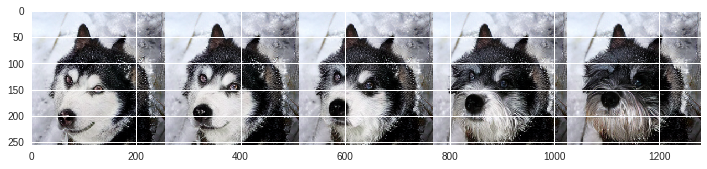

In [29]:
#preview
gen_imgs = np.asarray(Image.open("log/gen_spatially_interpolated_images/interpolated_images.png"))
plt.figure(figsize=(12,3))
plt.imshow(gen_imgs)

### 4-2. semantic transplantation

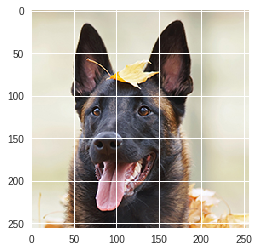

In [39]:
# download reference image
!wget "https://drive.google.com/uc?export=download&id=141usV4lSXw2Wl6c2YoebTI3hobb93uJt" -q -O reference.png

patch_ref = np.array(Image.open("reference.png"))
plt.imshow(patch_ref)

In [0]:
# manifold projection of reference image
ref_class = 235 - 151

argument = "--config_path ./configs/sn_projection_dog_and_cat_256_auxab.yml \
--gpu 0 \
--gen_model ./sn_projection_dog_and_cat_256_large/ResNetAuxABGenerator_75000.npz \
--dis_model ./sn_projection_dog_and_cat_256_large/SNResNetProjectionDiscriminator_450000.npz \
--enc_model ./sn_projection_dog_and_cat_256_large/ResNetEncoder_450000.npz \
--src_class {} \
--input reference.png \
--iter_opt 200 \
--mode aux".format(ref_class)

!python optimization.py $argument
!mv opt_output/opt_final.npy ref.npy

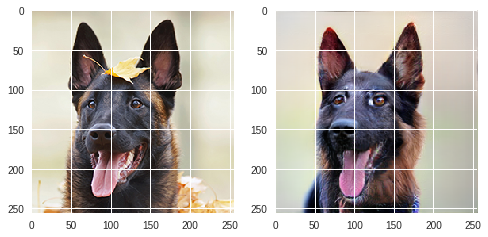

In [41]:
# preview
patch_recon = np.asarray(Image.open("opt_output/opt_final.png"))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(patch_ref)
plt.subplot(1,2,2)
plt.imshow(patch_recon)

In [0]:
# perform blending
arguments = "--gpu 0 \
--config ./configs/sn_projection_dog_and_cat_256_scbn.yml \
--snapshot sn_projection_dog_and_cat_256_large/ResNetGenerator_450000.npz \
--results_dir log/gen_spatially_interpolated_images_with_feature_blend \
--z1 ./src.npy \
--z2 ./ref.npy \
--class_mask ./examples/mask_1.png \
--classes {} {}".format(src_class, src_class)

!python evaluations/gen_spatially_interpolated_images_with_feature_blend.py $arguments

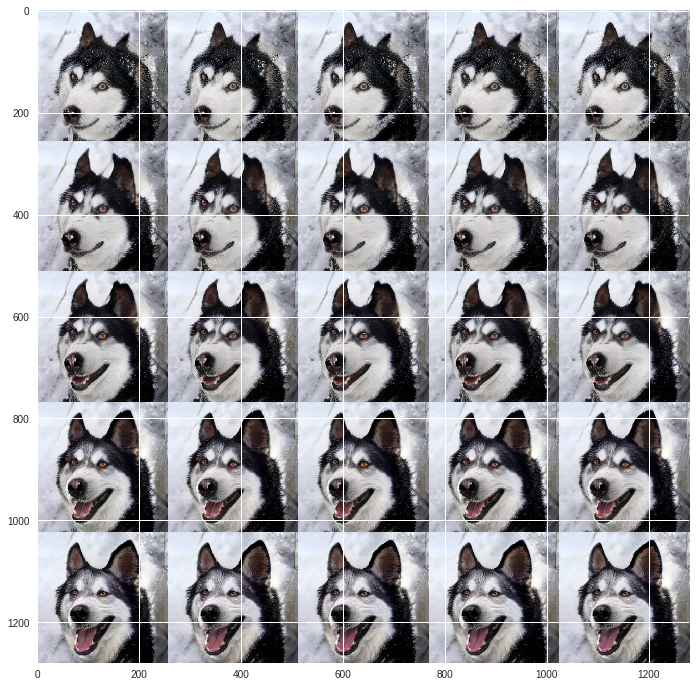

In [56]:
#preview
gen_imgs = np.asarray(Image.open("log/gen_spatially_interpolated_images_with_feature_blend/interpolated_images.png"))
plt.figure(figsize=(12,12))
plt.imshow(gen_imgs)

### 4-3. class-translation + semantic transplantation

In [0]:
# perform blending
arguments = "--gpu 0 \
--config ./configs/sn_projection_dog_and_cat_256_scbn.yml \
--snapshot sn_projection_dog_and_cat_256_large/ResNetGenerator_450000.npz \
--results_dir log/gen_spatially_interpolated_images_with_feature_blend \
--z1 ./src.npy \
--z2 ./ref.npy \
--class_mask ./mask.png \
--classes {} {}".format(src_class, target_class)

!python evaluations/gen_spatially_interpolated_images_with_feature_blend.py $arguments

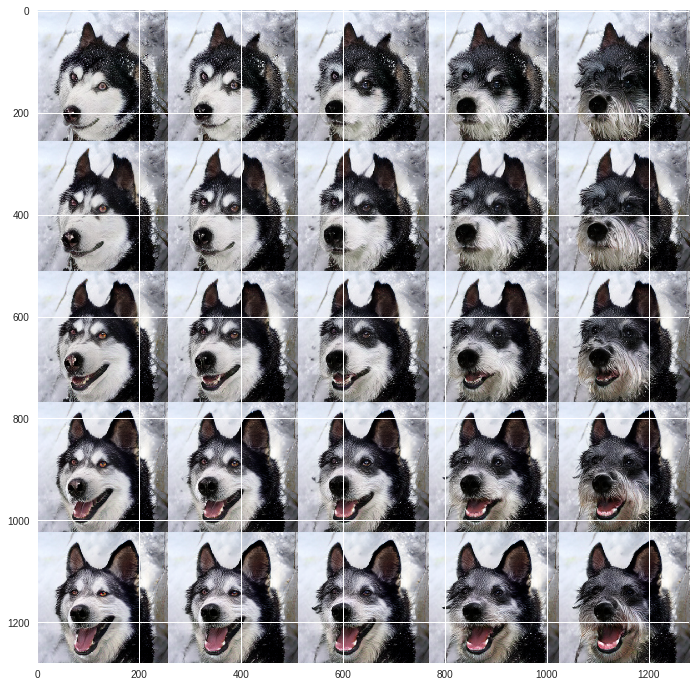

In [58]:
#preview
gen_imgs = np.asarray(Image.open("log/gen_spatially_interpolated_images_with_feature_blend/interpolated_images.png"))
plt.figure(figsize=(12,12))
plt.imshow(gen_imgs)

## 5. post-processing

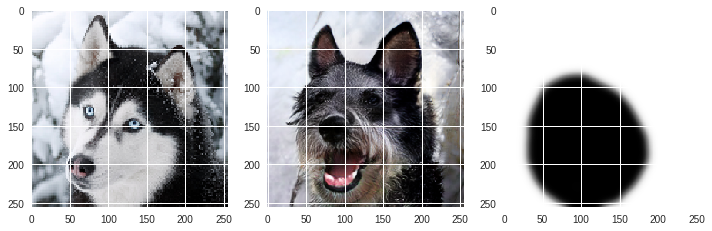

In [97]:
# crop generated image patch
gen_imgs = np.asarray(Image.open("log/gen_spatially_interpolated_images_with_feature_blend/interpolated_images.png"))
patch_result = gen_imgs[256*4:,256*4:,:]

# load mask
src = np.array(Image.open("patch_src.png").resize((256,256)), dtype=np.float32) / 255.0
overlay = np.array(patch_result, dtype=np.float32) / 255.0
raw_mask = np.array(Image.open("mask.png").resize((256,256)), dtype=np.float32)[:,:,0] / 255.0

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(src)
plt.subplot(1,3,2)
plt.imshow(overlay)
plt.subplot(1,3,3)
plt.imshow(raw_mask)

In [0]:
import poissonblending

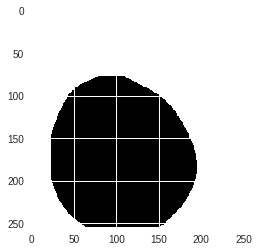

In [101]:
# binarize mask
mask = np.array(raw_mask)
mask[mask > 0.1] = 1.0
mask[mask < 1.0] = 0.0
mask[0,:] = 0.0
mask[:,0] = 0.0
mask[255,:] = 0.0
mask[:,255] = 0.0
plt.imshow(mask)

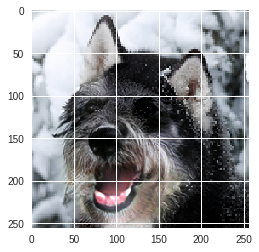

In [102]:
# execute poisson blending
result = np.clip(poissonblending.blend(src, overlay, mask, offset=(0, 0)), 0, 1.0)
plt.imshow(result)

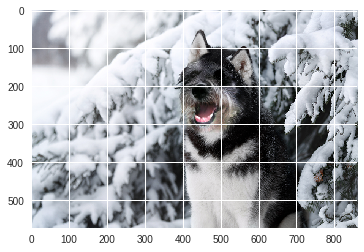

In [106]:
# paste to the original image
final_result = np.array(img_src[:,:,:3], dtype=np.float32) / 255.0
final_result[top:top+side_of_region, left:left+side_of_region, :] = cv2.resize(result, (side_of_region, side_of_region))
plt.imshow(final_result)